In [13]:
import pandas as pd
import numpy as np
import os


In [14]:
labels=pd.read_csv('labels.csv')
labels.head()

,swim_id,stroke
0,eca387ee-efe3-4b52-b4ba-2ad59f9b3c56,Freestyle
1,ecc649a0-e9b7-4d89-bdb4-5446913720bf,Freestyle
2,9c3a0f82-003d-43d7-975a-0e63c2c59657,Freestyle
3,3b3dff00-08d4-4e19-8b56-ac95be0d755e,Freestyle
4,f2c736be-8c1a-4016-9cc9-d7875b40e996,BackStroke


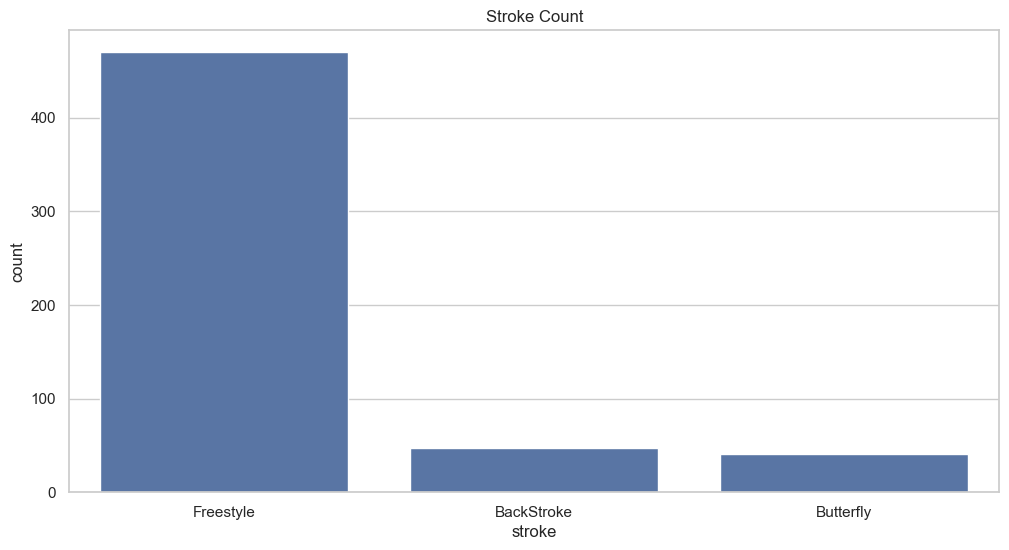

In [15]:
# show the count of stokes in labels in a bar chart
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="stroke", data=labels)
plt.title('Stroke Count')
plt.show()




In [16]:
dirs='../combined_2'
files=os.listdir(dirs)
files=[f for f in files
       if f.endswith('.csv')]
files[:10]

['0057f3aa-a1ec-4d6a-9776-846f6e8fd0e4.csv',
 '00798875-f5bc-4ffe-a4f6-b8c38ffb6a6f.csv',
 '00d6b11e-bbcb-4e5b-aadf-5dc7212fd92e.csv',
 '01082af2-c81b-407a-a7cd-3cbd58ef860f.csv',
 '01189fe4-b286-480e-a724-8f2ca82e2a2f.csv',
 '01d1cd74-b3ee-472f-bf85-b84318451509.csv',
 '0289f9c2-ef67-45cb-9793-e1c5846970d7.csv',
 '02b8a1b3-6a99-4a1e-98d5-dbbc3f1898b6.csv',
 '0370272b-09b1-40d4-8d72-6c86765b3d4e.csv',
 '03c79948-9b13-47b7-aba4-84619cd8b24b.csv']

In [17]:
labels[labels['swim_id']=='0057f3aa-a1ec-4d6a-9776-846f6e8fd0e4']['stroke'].values[0]


'BackStroke'

In [29]:
# print columns
df=pd.read_csv(os.path.join(dirs,files[0]))
print(df.columns)

Index(['timestamp_1', 'fPressureFront_1', 'fPressureSide_1',
       'acceleration.x_1', 'acceleration.y_1', 'acceleration.z_1',
       'quaternion.i_1', 'quaternion.j_1', 'quaternion.k_1',
       'quaternion.real_1', 'timestamp_2', 'fPressureFront_2',
       'fPressureSide_2', 'acceleration.x_2', 'acceleration.y_2',
       'acceleration.z_2', 'quaternion.i_2', 'quaternion.j_2',
       'quaternion.k_2', 'quaternion.real_2'],
      dtype='object')


In [18]:

data_lst=[]
label_lst = []
count=0
features=[ 'fPressureFront_1', 'fPressureSide_1',
       'acceleration.x_1', 'acceleration.y_1', 'acceleration.z_1',
       'quaternion.i_1', 'quaternion.j_1', 'quaternion.k_1',
        'fPressureFront_2',
       'fPressureSide_2', 'acceleration.x_2', 'acceleration.y_2',
       'acceleration.z_2', 'quaternion.i_2', 'quaternion.j_2',
       'quaternion.k_2' ]
for file in files:
    count += 1
    df = pd.read_csv(os.path.join(dirs, file))
    df = pd.read_csv(os.path.join(dirs, file))
    # Drop the rows with missing values
    df = df.dropna()

    data = df[features].values
    # split the data into 200 rows each, and append to the data_lst
    # This is done to match the labels with the data
    for i in range(200, min(7000,len(data)-200), 200):
        data_lst.append(data[i:i+200])
        file = file.split('.')[0]
        label_str = labels[labels['swim_id'] == file]['stroke'].values
        label_dict = {'Freestyle': 0, 'BackStroke': 1, 'Butterfly': 2, 'BreastStroke': 3}
        label = np.array([label_dict[label_str[0]]]) if label_str.size > 0 else np.array([])

        if label.size > 0:
            label_lst.append(label[0])
        else:
            print(f"No label found for file: {file}")
    
    if count % 100 == 0:
        print(f"Processed {count} files")

Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files


In [19]:
len(label_lst)

13306

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_lst, label_lst, test_size=0.1, random_state=42, stratify=label_lst
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.11, random_state=42, stratify=y_train
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 10657
Validation size: 1318
Test size: 1331


In [21]:
# show the distribution of the labels in the train, validation and test sets
from collections import Counter

print("Train set distribution")
print(Counter(y_train))
print("Validation set distribution")
print(Counter(y_val))
print("Test set distribution")
print(Counter(y_test))


Train set distribution
Counter({0: 9477, 1: 717, 2: 463})
Validation set distribution
Counter({0: 1172, 1: 89, 2: 57})
Test set distribution
Counter({0: 1184, 1: 89, 2: 58})


In [22]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


In [23]:
class SwimDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.LongTensor([self.targets[idx]])[0]

train_dataset = SwimDataset(X_train, y_train)
val_dataset = SwimDataset(X_val, y_val)
test_dataset = SwimDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [24]:
# print the shape of the data
data, target = next(iter(train_loader))
print(data.shape)
print(target.shape)
print(data[0].shape)


torch.Size([32, 200, 16])
torch.Size([32])
torch.Size([200, 16])


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Implement the transformer
input_size = 16    # Input feature dimension
hidden_size = 32   # Hidden layer size
num_classes = 4
num_epochs = 10
learning_rate = 0.005
num_heads = 4     # Number of attention heads
num_layers = 1    # Number of transformer layers
dropout_rate = 0.3

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_heads, num_layers, dropout_rate):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x.transpose(0, 1))
        x = x[-1, :, :]
        x = self.dropout(x)
        out = self.fc(x)
        return out

# Assuming you have your data loaded in X_train, y_train, X_val, y_val
# Convert data to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Initialize model, loss function, and optimizer
model = TransformerModel(input_size, hidden_size, num_classes, num_heads, num_layers, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        # Calculate other metrics like accuracy, F1-score, etc.


c:\Users\yixua\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


KeyboardInterrupt: 

In [122]:
#test the model on the test set
total = 0
correct = 0
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {(correct/total):.4f}')


Test Accuracy: 0.9601


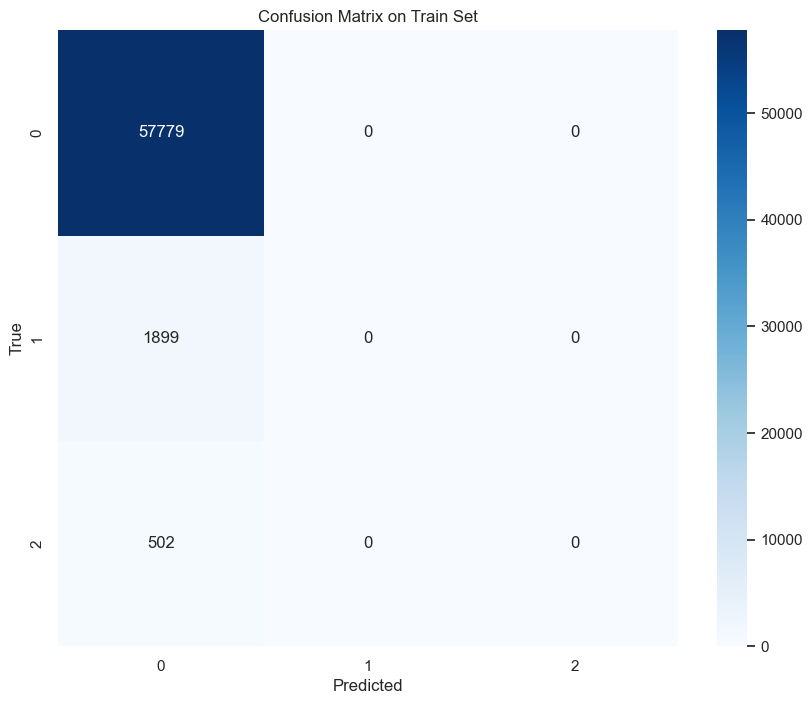

In [132]:
# show the confusion matrix on the train set
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # Switch to evaluation mode
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Train Set')
plt.show()


In [130]:
label_dict

{'Freestyle': 0, 'BackStroke': 1, 'Butterfly': 2, 'BreastStroke': 3}

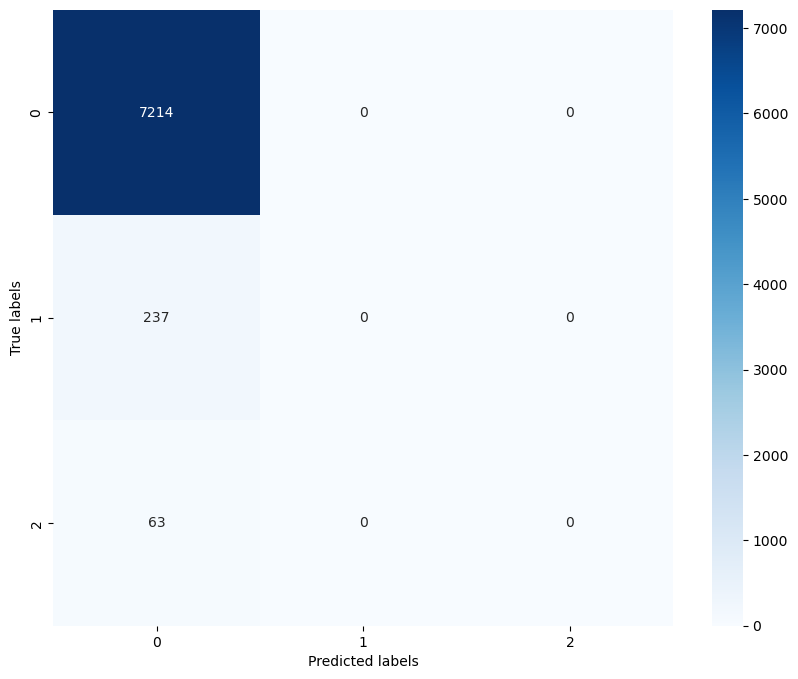

In [123]:
# show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # Switch to evaluation mode
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [131]:
# output the model parameters to a file
torch.save(model.state_dict(), 'transformer_model.pth')